In [1]:
import sys
import os
sys.path.insert(0, "../../python")
sys.path.insert(0, "../../litos")

import numpy as np
import particle_beam as pb
import plasma_source as ps
import particle_beam_propagation as pbp
import scipy.constants as const

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import beam.calc.electron as ecalc
import scipy.constants as const

import matplotlib.mlab as mlab
import nat_consts as nc
import particle_beam as pb
import plasma_source as ps
import particle_beam_propagation as pbp
import mike_math as mm
from   calc_M import calc_M
import scipy.stats as stats
import scipy.optimize as opt
from collections import defaultdict
import beam_ana as ba
import scipy.spatial as spatial
from matplotlib.ticker import FormatStrFormatter

path = '/mnt/md0/Data/Kurtosis_Saturation/'

In [2]:
# define plasma bulk (flat-top) properties
npl0   = 5e16                      # cm^-3, plasma density
dEds0  = np.sqrt(npl0/(5e16))*16.67e9  # eV/m, energy gain rate
dgds0  = dEds0/nc.me               # 1/m, energy gain rate for rel. gamma
L_ft   = 10.0                     # m, length of flat-top
    
# define plasma up-ramp
shape_up = 'gauss' # shape of ramp
hw_up    = 0.0  # m, half-width of ramp
L_up     = 0.0 # m, full length of ramp
top_up   = L_up    # m, relative location of ramp top
    
# define plasma down-ramp
shape_dn = shape_up # shape of ramp
hw_dn    = hw_up    # m, half-width of ramp
L_dn     = L_up     # m, full length of ramp
top_dn   = 0        # m, relative location of ramp top
    
# define beam parameters
npart  = 100000   # number of macro particles
dist   = 'gauss' # distribution shape in trace space
gbC    = (10e9)/nc.me   # centroid relativistic lorentz factor
dgb    = 0.01    # relative energy spread (HWHM)
dz     = 0       # spread in z (HWHM)
eps    = 5.0e-6  # m-rad, normalized emittance
beta   = 0.01    # m, Twiss at vac. waist
alpha  = 0.00    # Twiss at vac. waist
gamma  = (1.0+alpha**2)/beta # 1/m, Twiss at vac. waist
    
# calculate betatron wave number in flat-top
wp0    = (5.64e4)*np.sqrt(npl0) # rad/s, plasma ang. freq. (flat-top)
kp0    = wp0/nc.c               # 1/m, plasma wave number (flat-top)
kb     = kp0/np.sqrt(2*gbC)     # 1/m, betatron wave number (flat-top)

# make beam at vac. waist
s0     = 0.0 # m
twiss  = pb.make_twiss(beta,alpha,gamma,eps,gbC,dgb,dz)
parts  = pb.make_parts(twiss[0],npart,dist)
ebeam  = pb.make_ebeam(s0,twiss[0],parts[0])
    
# set beam waist position
waist = 0.0       # m, waist location w.r.t L_up
s_w   = L_up + waist # m, absolute wasit location
    
# define longitudinal steps
ds   = (1.0/kb)*(1./10.)                  # m, step size
s_ft = np.linspace(0,L_ft,int(L_ft/ds+1)) # m, steps for flat-top
s_up = np.linspace(0,L_up,int(L_up/ds+1)) # m, steps for up-ramp
s_dn = np.linspace(0,L_dn,int(L_dn/ds+1)) # m, steps for down-ramp

# make plasma
bulk    = ps.make_bulk(s_ft,npl0,dgds0)
up_ramp = ps.make_ramp(s_up,'up',shape_up,hw_up,top_up,npl0,dgds0)
dn_ramp = ps.make_ramp(s_dn,'dn',shape_dn,hw_dn,top_dn,npl0,dgds0)
plasma  = ps.make_plasma(bulk,up_ramp,dn_ramp) # output: plasma dict.

Nz: 21249
dgds0: 32622.3091977


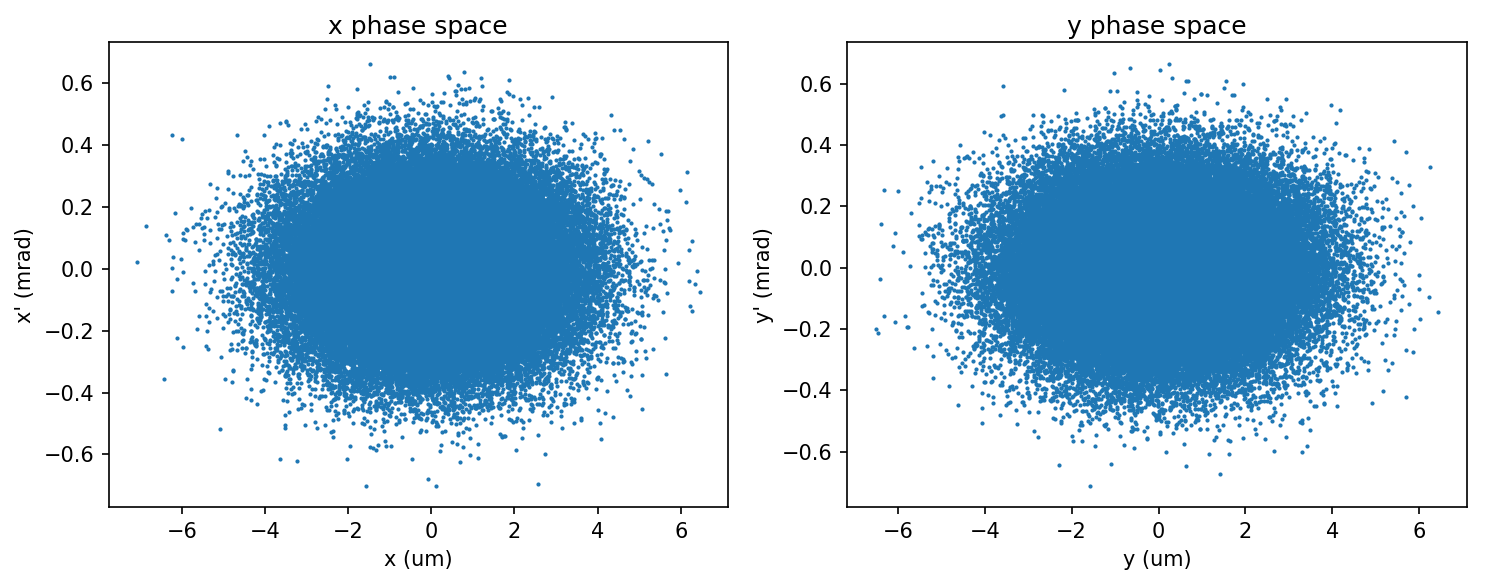

In [3]:
s = plasma['s']
z = s*1e6
ne = plasma['npl']/1e17
Nz = len(z)
print('Nz:', Nz)
print('dgds0:', dgds0)
# Now we can test my code and see if it is different
betaBeam = beta+(-s_w)**2/beta
alphaBeam = s_w/beta
electronParams = {
    'name' : '5e16',
    'path' : path,
    'load' : False,
    'N' : npart,
    'gamma' : gbC,
    'emittance' : eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : dgb
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        npl = ne*1e17
        dgdz = dgds0*np.sqrt(npl/npl0)*(2*np.sqrt(npl/npl0)-1)
        return dgdz*1e-6
    
plasmaDen = plasmaCls()
dumpPer = 20
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 20)
beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, gbC, dgds0, npl0/1e17)

In [4]:
# Handle the dump periodicity
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, z[-1], m)*1e-6
dz = z[-1]/(m-1)
beam_ne = ne[::dumpPer]
beam_gb = gb[::dumpPer]

In [5]:
rms_x = np.zeros(m)
rms_x_eps = np.zeros(m)
un_kurt = np.zeros(m)
J_kurt  = np.zeros(m)
rms_beta = np.zeros(m)

frac = 1.0

for i in range(0, m):
    ptcls = beam.load_ptcls(i)[0]
    ebeam_rms = beam.get_beam_properties(i)
    rms_x[i]     = ebeam_rms["x"]/(1e-6)
    rms_x_eps[i] = ebeam_rms["x_eps"]/(1e-6)
    
    [u,v] = ba.real2norm_coords(beam.get_x(ptcls),beam.get_xp(ptcls),\
                                ebeam_rms["x_beta"],ebeam_rms["x_alpha"])
    J = (u**2+v**2)/2
    phi = np.arctan2(v,u)
    un = np.sqrt(2*J*beam_gb[i])*np.cos(phi)/np.sqrt(rms_x_eps[i])
    un_kurt[i] = stats.kurtosis(un,0,True)
    J_kurt[i] = stats.kurtosis(J,0,False,True)
    
    
i_flat_start = np.argwhere(plasma["s"]>=plasma["up_ramp"]["top_loc"])[0][0]

Tbeta   = beta[i_flat_start]
Talpha  = alpha[i_flat_start]
Tgamma  = gamma[i_flat_start]
TgbC    = gb[i_flat_start]
Twp0    = (5.64e4)*np.sqrt(plasma["bulk"]["npl0"]) # rad/s, plasma ang. freq.
Tkp0    = Twp0/nc.c # m^-1, plasma wave number
Tkb     = Tkp0/np.sqrt(2*TgbC)
Tbeta_m = 1.0/Tkb
TTbeam  = [Tbeta,Talpha,Tgamma]
TTmatch = [Tbeta_m,0,1.0/Tbeta_m]

BB      = ba.calc_Bmag(TTbeam,TTmatch)
print('Bmag: ',BB)
ent_z_v = s[0]+alpha[0]/gamma[0]
ent_beta_v = (1/gamma[0])/(1e-2)
exit_z_v = s[-1]+alpha[-1]/gamma[-1]
exit_beta_v = (1/gamma[-1])/(1e-2)

../../python/beam/beams/electronbeam.py:190: RuntimeWarning: invalid value encountered in sqrt
  prop['xxp']     = np.sqrt(sigmaxxp)


Bmag:  1.29775482353


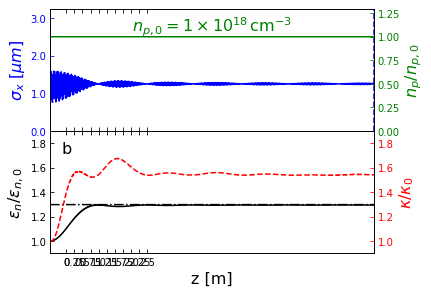

In [6]:
# which subfigure?
#subfig = 'a'
subfig = 'b'
xlim = [0.0, 10.0]

figA, (ax1, ax3) = plt.subplots(2, sharex=True, sharey=False)

ax1.plot(beam_z,rms_x,color='b',linestyle='solid')
ax1.set_ylabel(r'$\sigma_x$ [$\mu m$]',color='b',fontsize=16)
ax1.tick_params('y',colors='b')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.set_ylim([0,3.25])
ax1.set_xlim(xlim)

ax1.plot([ent_z_v,ent_z_v],[0,6.5],color='b',linestyle='dashed')
ax1.plot([exit_z_v,exit_z_v],[0,6.5],color='b',linestyle='dashed')

npl = plasma["npl"]/plasma["bulk"]["npl0"]
ax2  = ax1.twinx()
ax2.plot(s,npl,color='g',linestyle='solid')
ax2.set_ylabel(r'$n_p/n_{p,0}$',color='g',fontsize=16)
ax2.tick_params('y',colors='g')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylim([0,1.3])
ax2.set_xlim(xlim)

# plasma density text
if subfig=='a':
    ax2.text(0.50, 0.85, r'$n_{p,0} = 5\times 10^{16} \,{\rm cm^{-3}}$',
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
elif subfig=='b':
    ax2.text(0.50, 0.85, r'$n_{p,0} = 1\times 10^{18} \,{\rm cm^{-3}}$',
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
else:
    ax2.text(0.50, 0.85, \
             r'$n_{p,0} = %2.1e \,{\rm cm^{-3}}$'%plasma["bulk"]["npl0"],
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
    
ax3.plot(beam_z,rms_x_eps/rms_x_eps[0],color='k',linestyle='-')
ax3.plot(s,BB*np.ones(len(s)),color='k',linestyle='-.')
ax3.set_ylabel(r'$\varepsilon_n/\varepsilon_{n,0}$',color='k',fontsize=16)
ax3.tick_params('y',colors='k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if subfig=='a':
    ax3.set_ylim([0.9875,1.0125]) # matched limits
elif subfig=='b':
    ax3.set_ylim([0.9,1.9]) # mismatched limits
else:
    ax3.set_ylim([0.9,1.9])
ax3.set_xlim(xlim)

if subfig=='a':
    ax3.text(0.05, 0.85, r'a',
        verticalalignment='center', horizontalalignment='center',
        transform=ax3.transAxes,
        color='black', fontsize=16)
elif subfig=='b':
    ax3.text(0.05, 0.85, r'b',
        verticalalignment='center', horizontalalignment='center',
        transform=ax3.transAxes,
        color='black', fontsize=16)

ax4 = ax3.twinx()
ax4.plot(beam_z,J_kurt/J_kurt[0],color='r',linestyle='--')
ax4.set_ylabel(r'$\kappa/\kappa_{0}$',color='r',fontsize=16)
ax4.tick_params('y',colors='r')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if subfig=='a':
    ax4.set_ylim([0.9875,1.0125]) # matched limits
elif subfig=='b':
    ax4.set_ylim([0.9,1.9]) # mismatched limits
else:
    ax4.set_ylim([0.9,1.9])
ax4.set_xlim(xlim)

ax1.tick_params(top=True,bottom=True,left=True,direction='in',length=4)
ax2.tick_params(direction='in',length=4)
ax3.tick_params(top=True,bottom=True,left=True,direction='in',length=4)
ax4.tick_params(direction='in',length=4)

xlabel_locs = [0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]
if subfig=='a':
    xlabels = []
elif subfig=='b':
    xlabels = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5]
else:
    xlabels = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5]
plt.xticks(xlabel_locs, xlabels)

if subfig=='a':
    ax3.set_xlabel('',fontsize=16)
elif subfig=='b':
    ax3.set_xlabel('z [m]',fontsize=16)
else:
    ax3.set_xlabel('z [m]',fontsize=16)

# copy and past these two lines into console to remove
# x-axis title and tick marks after initial plot is made
#ax3.set_xlabel('',fontsize=16) # remove x-axis label
#ax3.get_xaxis().set_ticks([]) # remove x-axis ticks

# I know it appears redundant, but keep these here!
ax1.set_xlim(xlim)
ax3.set_xlim(xlim)

ax1.set_position([0.125,0.550,0.75,0.425])
ax2.set_position([0.125,0.550,0.75,0.425])
ax3.set_position([0.125,0.125,0.75,0.425])
ax4.set_position([0.125,0.125,0.75,0.425])

#figA.tight_layout()
#figA.subplots_adjust(hspace=0)
#plt.savefig(path+'PRL_Fig1_a.eps', format='eps')
#plt.savefig(path+'PRL_Fig1_a.png', format='png', dpi=900)
plt.show()

In [7]:
Nz = 20000
ne0 = 5e16
betaBeam = 0.01
dumpPer = 10
z = np.linspace(0.0, 10.0, Nz)*1e6
ne = np.ones(Nz)*ne0/1e17
dEds0  = np.sqrt(ne0/(5e16))*16.67e9  # eV/m, energy gain rate
dgds0  = dEds0/nc.me               # 1/m, energy gain rate for rel. gamma
alphaBeam = 0.0
electronParams = {
    'name' : '5e16',
    'path' : path,
    'load' : False,
    'N' : 100000,
    'gamma' : gbC,
    'emittance' : eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : dgb
}

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        npl = ne*1e17
        dgdz = dgds0*np.sqrt(npl/npl0)*(2*np.sqrt(npl/npl0)-1)
        return dgdz*1e-6
    
plasmaDen = plasmaCls()
m = int(Nz/dumpPer)

In [8]:
M = 50
betaM = np.sqrt(2*gbC) / (5.95074e4 * np.sqrt(ne0/1e17))
betaTest = np.linspace(0.005, 0.015, M)
Bmag = 0.5*(betaTest/betaM + betaM/betaTest)
Kurt = np.zeros(M)
Kurt0 = np.zeros(M)
for i in range(M):
    print('Bmag: ', Bmag[i])
    betaBeam = betaTest[i]
    electronParams['name'] = 'beta-%0.2f' % betaBeam
    electronParams['betax'] = betaBeam,
    electronParams['betay'] = betaBeam,
    beam = electronbeam.GaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 20)
    beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, gbC, dgds0, ne0/1e17)
    
    ptcls = beam.load_ptcls(0)[0]
    ebeam_rms = beam.get_beam_properties(0)    
    [u,v] = ba.real2norm_coords(beam.get_x(ptcls),beam.get_xp(ptcls),\
                                ebeam_rms["x_beta"],ebeam_rms["x_alpha"])
    J = (u**2+v**2)/2
    Kurt0[i] = stats.kurtosis(J,0,False,True)
    
    ptcls = beam.load_ptcls(m)[0]
    ebeam_rms = beam.get_beam_properties(m)    
    [u,v] = ba.real2norm_coords(beam.get_x(ptcls),beam.get_xp(ptcls),\
                                ebeam_rms["x_beta"],ebeam_rms["x_alpha"])
    J = (u**2+v**2)/2
    #print('Kurt0: ', Kurt0)
    Kurt[i] = stats.kurtosis(J,0,False,True)

Bmag:  1.00189346777
Bmag:  1.00515897695


../../python/beam/beams/electronbeam.py:190: RuntimeWarning: invalid value encountered in sqrt
  prop['xxp']     = np.sqrt(sigmaxxp)


Bmag:  1.00981601593
Bmag:  1.01571278147
Bmag:  1.02271877602
Bmag:  1.03072119664
Bmag:  1.0396220342
Bmag:  1.0493357252
Bmag:  1.05978723699
Bmag:  1.07091049608
Bmag:  1.08264708967
Bmag:  1.09494518665
Bmag:  1.10775863608
Bmag:  1.12104620976
Bmag:  1.13477096293
Bmag:  1.1488996921
Bmag:  1.16340247312
Bmag:  1.17825226608
Bmag:  1.19342457604
Bmag:  1.20889716044
Bmag:  1.22464977606
Bmag:  1.2406639593
Bmag:  1.25692283483
Bmag:  1.27341094841
Bmag:  1.29011412035
Bmag:  1.30701931683
Bmag:  1.32411453638
Bmag:  1.34138870969
Bmag:  1.35883161084
Bmag:  1.37643377845
Bmag:  1.39418644557
Bmag:  1.41208147708
Bmag:  1.43011131381
Bmag:  1.44826892245
Bmag:  1.46654775059
Bmag:  1.48494168632
Bmag:  1.50344502183
Bmag:  1.52205242054
Bmag:  1.54075888743
Bmag:  1.5595597421
Bmag:  1.57845059442
Bmag:  1.59742732237
Bmag:  1.61648605186
Bmag:  1.63562313837
Bmag:  1.65483515021
Bmag:  1.67411885319
Bmag:  1.69347119663
Bmag:  1.7128893005
Bmag:  1.73237044369
Bmag:  1.7519120531

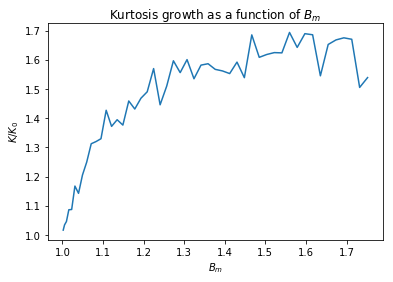

8.94045432141
[  8.96491888   8.80436443   9.20531295  10.06935968   9.38797697
  10.33373642  10.40837354  10.81580311  11.16193986  11.24450927
  11.97816271  12.21771858  12.78738123  12.2091654   12.07997987
  12.34642055  12.61378986  12.81056364  13.35545977  13.52568596
  15.2273129   12.93765465  13.68520955  14.58453624  13.82090526
  13.68652184  13.87475701  14.55931571  14.17428769  14.00200136
  14.05587706  14.02157155  14.21481086  13.36138456  15.20254319
  14.3023899   14.12070262  14.37886268  14.82506643  14.95840158
  14.51518918  14.96002496  15.19029436  14.40971537  14.05691418
  14.23461395  14.83557211  15.22514859  14.42552043  13.82807444]


In [10]:
plt.plot(Bmag, Kurt/Kurt0)
plt.title(r'Kurtosis growth as a function of $B_m$')
plt.xlabel(r'$B_m$')
plt.ylabel(r'$K/K_0$')
plt.show()
print(np.average(Kurt0))